#Assignment 3 - Application of Sampling
## Ravida Saitova, BS18-DS01
### April 2022


#### The goal for this homework is to implement an optimization algorithm called simulated Annealing (SA). 

##### Imports

In [1]:
from google.colab import drive
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import math
import numpy.random as random

##### Download the location data for cities in Russia

In [2]:
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/city-master.zip'
data = pd.read_csv('/content/city-master/city.csv')

Mounted at /content/drive
Archive:  /content/drive/MyDrive/city-master.zip
ae661bffe572880472249097c9b29c42b09650ea
   creating: city-master/
  inflating: city-master/README.md   
  inflating: city-master/city.csv    
  inflating: city-master/city.csv-metadata.json  


##### Find the  30 most populated cities in Russia

In [3]:
data.sort_values(by = ['population'], ascending=False, inplace=True)
sorted = data[['address','geo_lat','geo_lon']][:30]
sorted

,address,geo_lat,geo_lon
509,г Москва,55.754047,37.620405
786,г Санкт-Петербург,59.939131,30.315900
647,г Новосибирск,55.028191,82.921149
832,г Екатеринбург,56.838522,60.605491
619,г Нижний Новгород,56.324063,44.005391
927,г Казань,55.794358,49.111497
782,г Самара,53.195031,50.106952
656,г Омск,54.984857,73.367452
1064,г Челябинск,55.160262,61.400808
757,г Ростов-на-Дону,47.222457,39.718803


##### Calculate distances matrix among the cities

In [4]:
# coordinate (latitude, longitude)
distances = np.zeros((30,30))

for origin in range(30):
  for dest in range(30):
    distances[origin][dest] = geodesic((sorted['geo_lat'].iloc[origin], sorted['geo_lon'].iloc[origin]),(sorted['geo_lat'].iloc[dest], sorted['geo_lon'].iloc[dest])).kilometers

##### Function to compute energy value for given x, in our case it is the total travelled distance

In [5]:
def dist(path):
  total = 0
  for i in range(1,len(path)):
    total += distances[path[i-1]][path[i]]
  # close the circle by traveling back to the initial city
  total += distances[path[-1]][path[0]]
  return total

##### Fuction for Proposal distribution 

In [6]:
def g(x):
  candidate = x.copy()
  i,j =  np.random.choice(candidate, 2, replace=False)
  candidate[i],candidate[j] = candidate[j],candidate[i]
  return candidate

##### Function to calculate acceptance ratio that further will be used to accept/reject canditate samples:

$α=\frac{p^*(x')}{p^*(x_t)} = \frac{e^{-\frac{dist(x')}{T}}}{e^{-\frac{dist(x_t)}{T}}} = e^{-\frac{dist(x') - dist(x_t)}{T}}$


In [7]:
# Imput is computed energy values, in our case the total travelled distance
def ar(old, new, T):
  return math.exp(-(new-old)/T)

Fuction of Simulated Annealing:
1. Sample initial $x_0$, set time step $t = 0$;
2. Set initial temperature T. To avoid problems with numerical overflow when calculating the exponent, set the temperature comparable with the initial value of the system’s energy;
3. Generate $x'$ from $g(x'|xt)$. For continuous problems, the common solution
is to use the normal distribution;
4. Calculate acceptance ratio $\alpha = \frac{p(x')}{ p(x_t)}$ ;
5. Generate $u ∼ U(0, 1)$. If $u \leq \alpha$, accept the new state $x_{t+1} = x'$ , otherwise propagate the old state. Pass $x_t+1$ to the output of the sampler;
6. Reduce temperature T. Temperature annealing does not have to take place on every iteration. The temperature can be decreased every N iteration as well. There is no strict rule about this;
7. Increment t;
8. Repeat 2-8 until cooled down. The solution can be sampled before the
system is cooled down, but we have no way of knowing whether this was
the optimal solution


In [8]:
def SA(a,step):
  # Lists to save all needed information
  states = []
  temps = []
  dists = []

  # Starting values
  x = random.permutation(30)
  t = 0
  T = 30**2

  states.append(x)
  dists.append(dist(x))
  temps.append(T)

  # Until temperature is not the limit 
  while T > 15:
    # generate candidate
    new = g(x)
    # compute acceptance ratio
    ratio = ar(dist(x),dist(new),T)
    # acceptance criteria
    if random.uniform() <= ratio:
      x = new

    # The number of steps we do not decrease the temperature
    if (t % step == 0)   :
      T *= a
    t += 1
    
    states.append(x)
    dists.append(dist(x))
    temps.append(T)
    if T < 20:
      break

  return states, dists, temps

##### Compare the for your selected annealing schedule, track the speed of convergence for three different values of the annealing rate (try fast cooling, slow cooling, and some middle value). Compare the optimization result;


In [12]:
states_fast, dists_fast, temps_fast = SA(0.9,5)
states_medium, dists_medium, temps_medium = SA(0.95,5)
states_slow,  dists_slow, temps_slow = SA(0.99,5)

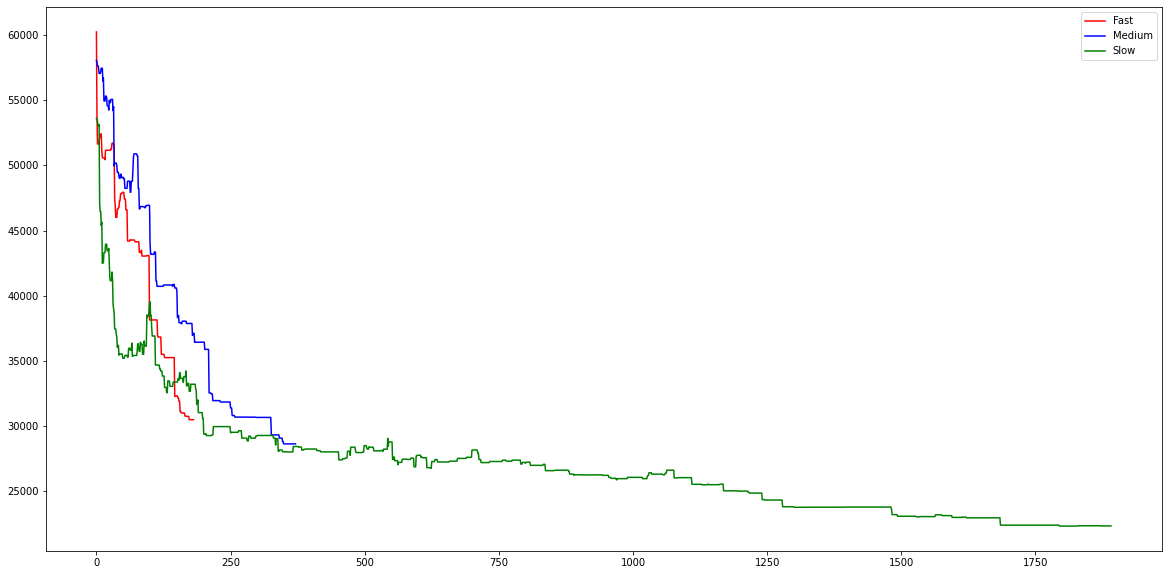

In [13]:
import matplotlib.pyplot as plt
# plot the difference
plt.figure(figsize=(20, 10))
plt.plot(range(len(temps_fast)), dists_fast, color = 'r', label='Fast')
plt.plot(range(len(temps_medium)), dists_medium, color = 'b',label='Medium')
plt.plot(range(len(temps_slow)), dists_slow,color = 'g', label='Slow')
plt.legend()
plt.show()

The results show what we can achieve with this algorithm choosing different speed of cooling down. Choosing high cooling rate produce faster results but we can not achieve global minima at some cases or even stop at the local one. 

##### Produce a visualization of your optimization process. 


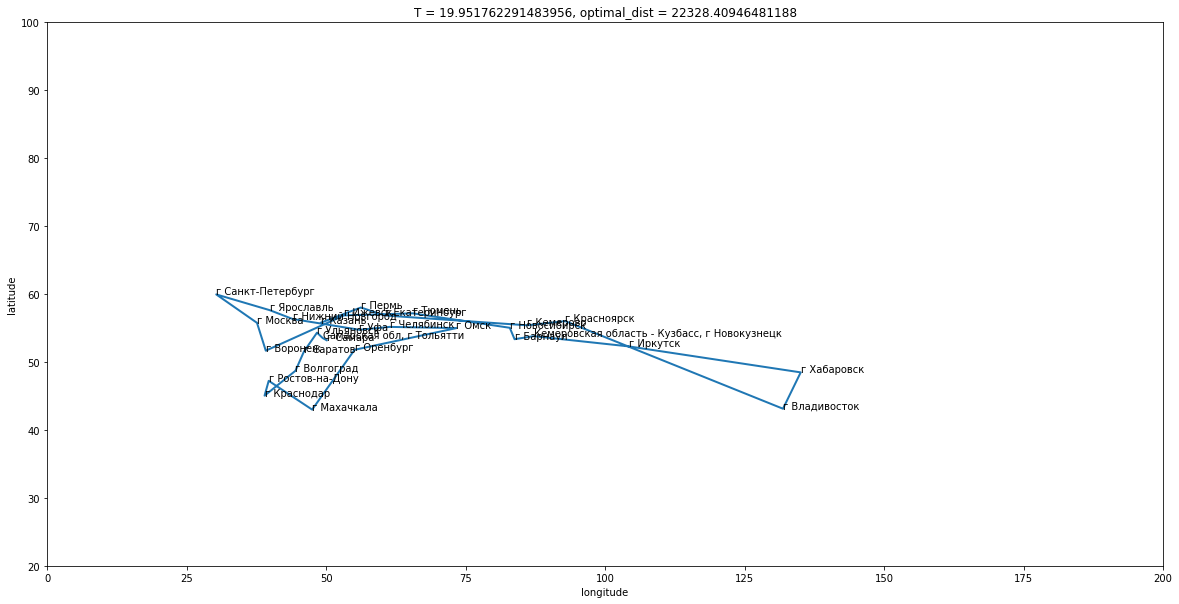

In [14]:
# used: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/
from matplotlib import animation

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(xlim=(0, 200), ylim=(20, 100))
plt.ylabel('latitude')
plt.xlabel('longitude')
line, = plt.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
  x = []
  y = []
  state = states_slow[i]
  for s in state:
    y.append(sorted['geo_lat'].iloc[s])
    x.append(sorted['geo_lon'].iloc[s])
  
  ax.title.set_text(f"T = {temps_slow[i]}, optimal_dist = {dists_slow[i]}")
  line.set_data(x, y)
  return line,

anim = animation.FuncAnimation(fig, animate, frames=len(states_slow), interval=20, init_func=init, blit=True)

for i, city in enumerate(sorted['address']):
  ax.annotate(city, (sorted['geo_lon'].iloc[i], sorted['geo_lat'].iloc[i]))

anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()